In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import network, vis, patternLib
from tqdm import tqdm
from keras.datasets import mnist
import random

### Load the MNIST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]
print(f"Number of images in train dataset: {n_train}")
print(f"Number of images in the test dataset: {n_test}")

Number of images in train dataset: 60000
Number of images in the test dataset: 10000


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Images are currently in the form of 28*28 size matrices

### Classification using a Hopfield Network

**Strategy: Store a pattern for each digit (using the average of train data for each digit, by balanced binarization of pixel values)**

In [ ]:
# flatten out the image vectors for preprocessing
X_train = x_train.reshape(n_train, 784)
X_test = x_test.reshape(n_test, 784)

In [ ]:
# scaling factor to normalize pixel values
factor = 2.0 / np.max( X_train )

# create an average pattern for each image label (0 to 9)
def calculate_avg_classes():
    unique_labels = np.unique(y_train)
    avg_patterns = []
    for l in unique_labels:
        class_mean = np.mean(X_train[y_train == l, :], axis=0)
        scaled_mean = factor * class_mean - 1.0
        avg_patterns.append(scaled_mean)
    return np.array(avg_patterns)

patterns = calculate_avg_classes()

In [ ]:
# Convert the patterns to {-1,1} matrices, using balanced binarization
low = -1.0
high = 1.0
iters = 10
balance = np.zeros( iters )
threshold = np.zeros( iters )

for i in tqdm( range( iters ) ):
    threshold[ i ] = ( low + high ) / 2
    balance[ i ] = np.mean( np.where( patterns < threshold[ i ], -1, 1 ) )
    if balance[ i ] > -0.7:
        low = threshold[ i ]
    else:
        high = threshold[ i ]

binary_patterns = np.where( patterns < threshold[ -1 ], -1, 1 )

# convert the test data to binarized form
X_test_binarized = np.where( ( factor * X_test - 1 ) < threshold[ -1 ], -1, 1 )

100%|██████████| 10/10 [00:00<00:00, 3130.08it/s]


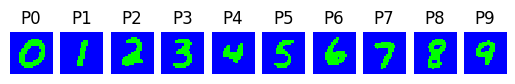

In [ ]:
# reshape the training pattern list for better visualization
plist = list(binary_patterns.reshape(10,28,28))
vis.see_pattern_list(plist)

**Hopfield Network Initialization and Training**

In [ ]:
# create a hopfield network consisting of 28*28 neurons
pattern_size = 28
hopfield_net = network.myHopfieldNetwork(pattern_size**2)

In [ ]:
# train the model using the 'pseudo-inverse' rule instead of hebb's rule, as it is more adept at memorizing more number of patterns
wgts = hopfield_net.calculate_weights(plist, rule = "pseudo-inverse")

In [ ]:
# reshape the test data for prediciton using hopfield network
test_patterns = X_test_binarized.reshape(n_test,28,28)

Retrieval of random test image

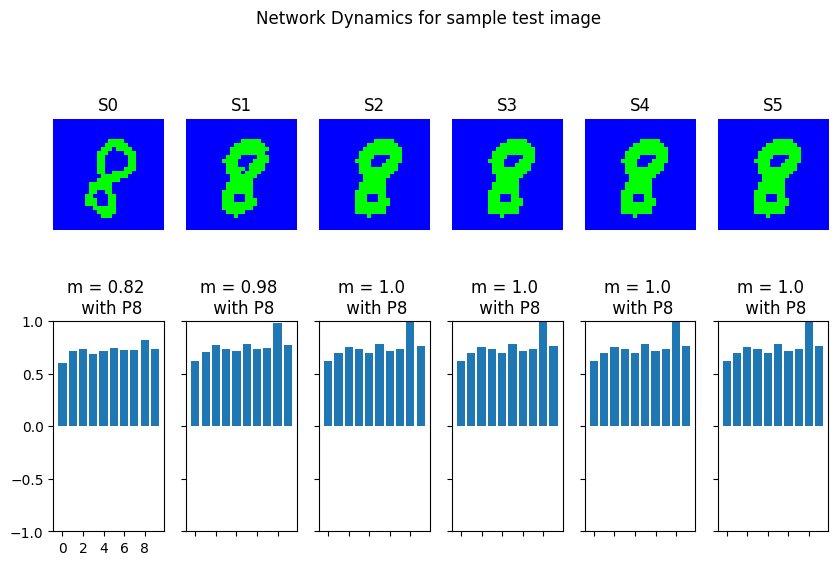

In [ ]:
# selecting random image from test data
S = random.choice(test_patterns)
# store the evolution of states
state_list = hopfield_net.network_evolution(S,wgts, 5)
# plot the evolution
vis.plot_state_sequence_and_overlap(state_list,plist,suptitle="Network Dynamics for sample test image")

The above plot shows the maximum overlap with any particular pattern at each stage of network evolution

**Test Images Classification**

Classification for test data takes about 1 minute

In [ ]:
# stores the predictions made by hopfield network
y_preds = []
for i in tqdm(range(len(test_patterns)), desc="Processing patterns"):
  # store the network evolution on test_image_{i}
  state_list = hopfield_net.network_evolution(test_patterns[i],wgts, 5)
  # compute the overlap of the final state with each of the stored patterns
  overlap_list = patternLib.compute_overlap_list(state_list[-1], plist)
  # classify the image as the index of the stored pattern with the maximum overlap
  max_idx = np.argmax(overlap_list)
  y_preds.append(max_idx)

Processing patterns: 100%|██████████| 10000/10000 [01:08<00:00, 146.43it/s]


**Model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score
overall_accuracy = accuracy_score(y_preds, y_test)
print(f'Overall Accuracy: {round(overall_accuracy,2)*100}%')

Overall Accuracy: 70.0%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.67      0.79       980
           1       0.51      0.98      0.67      1135
           2       0.87      0.55      0.68      1032
           3       0.71      0.70      0.70      1010
           4       0.70      0.70      0.70       982
           5       0.52      0.55      0.54       892
           6       0.83      0.71      0.77       958
           7       0.76      0.80      0.78      1028
           8       0.81      0.54      0.65       974
           9       0.68      0.70      0.69      1009

    accuracy                           0.69     10000
   macro avg       0.74      0.69      0.70     10000
weighted avg       0.73      0.69      0.70     10000

